In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import Utils.dataframe as dataframe_helper
import Utils.learning as learning
import mlflow

In [3]:
experiment_name = "Unigram Model"

In [4]:
pd.set_option('display.max_columns', None)
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='../mlruns/421321982855576860', creation_time=1672897819233, experiment_id='421321982855576860', last_update_time=1672897819233, lifecycle_stage='active', name='Unigram Model', tags={}>

## Feature Engineering

In [5]:
def feature_engineering_one_hot(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL one hot encoding
    fakeWordOneHot = []
    nonFakeWordOneHot = []

    for content in df['reviewContent']:
        fakeOneHot = ''
        nonFakeOneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)

        for word in fake_words:
            if word in words:
                fakeOneHot += '1'
            else:
                fakeOneHot += '0'

        for word in non_fake_words:
            if word in words:
                nonFakeOneHot += '1'
            else:
                nonFakeOneHot += '0'
                
        fakeWordOneHot.append(fakeOneHot)
        nonFakeWordOneHot.append(nonFakeOneHot)
    
    result = pd.DataFrame()
    result['fakeWordsOneHot'] = fakeWordOneHot
    result['nonFakeWordsOneHot'] = nonFakeWordOneHot

    result = dataframe_helper.onehot(result, 'fakeWordsOneHot', fake_words, 'fake')
    result = dataframe_helper.onehot(result, 'nonFakeWordsOneHot', non_fake_words, 'non fake')
    
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

In [6]:
def feature_engineering_word_count(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL word count
    fakeWordsCount = []
    nonFakeWordsCount = []

    for content in df['reviewContent']:
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)
        fakeCount = 0
        nonFakeCount = 0
        for word in words:
            if word in fake_words:
                fakeCount += 1
            elif word in non_fake_words:
                nonFakeCount += 1
        fakeWordsCount.append(fakeCount)
        nonFakeWordsCount.append(nonFakeCount)

    result = pd.DataFrame()
    result['fakeWordsCount'] = fakeWordsCount
    result['nonFakeWordsCount'] = nonFakeWordsCount
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']
    
    return result
    

## Make train dataset

In [7]:
df = dataframe_helper.load_data()
df = dataframe_helper.data_cleaning(df)
df = feature_engineering_one_hot(df)
# df = feature_engineering_word_count(df)

c:\Users\Um_25\Desktop\project\yelp-fake-reviews\Code\..\Utils\dataframe.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][i] = df['date'][i][1:]
c:\Users\Um_25\Desktop\project\yelp-fake-reviews\Code\..\Utils\dataframe.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col_name[i]} ({type})'] = [data[i] for data in df[col]]
c:\Users\Um_25\Desktop\project\yelp-fake-reviews\Code\..\Utils\dataframe.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [8]:
df.head()

,food (fake),great (fake),service (fake),place (fake),restaurant (fake),best (fake),staff (fake),owner (fake),time (fake),pizza (fake),love (fake),manager (fake),always (fake),never (fake),would (fake),atmosphere (fake),told (fake),simply (fake),sushi (fake),asked (fake),went (fake),customer (fake),recommend (fake),waiter (fake),friends (fake),chicago (fake),family (fake),rude (fake),better (fake),wonderful (fake),eat (fake),going (fake),waitress (fake),minutes (fake),worst (fake),people (fake),vietnamese (fake),bad (fake),money (fake),customers (fake),experience (fake),prices (fake),friendly (fake),times (fake),table (fake),back (fake),years (fake),server (fake),wife (fake),italian (fake),fresh (fake),business (fake),birthday (fake),bill (fake),terrible (fake),party (fake),husband (fake),busy (fake),delivery (fake),ever (fake),city (fake),said (fake),bar (fake),week (fake),excellent (fake),amazing (fake),mexican (fake),last (fake),took (fake),new (fake),many (fake),price (fake),pho (fake),quality (fake),horrible (fake),say (fake),hostess (fake),called (fake),fogo (fake),far (fake),first (fake),highly (fake),sunda (fake),authentic (fake),appetizers (fake),favorite (fake),coast (fake),extremely (fake),steak (fake),nana (fake),treated (fake),left (fake),away (fake),evening (fake),make (fake),nice (fake),absolutely (fake),everyone (fake),care (fake),places (fake),persian (fake),town (fake),give (fake),offered (fake),sat (fake),kids (fake),anyone (fake),byob (fake),live (fake),fantastic (fake),work (fake),walked (fake),pay (fake),gave (fake),one (fake),attitude (fake),paid (fake),brazilian (fake),spacca (fake),girlfriend (fake),night (fake),lincoln (fake),management (fake),several (fake),host (fake),hands (fake),nuevo (fake),past (fake),guests (fake),reasonable (fake),soon (fake),brazzaz (fake),wait (fake),korean (fake),tuan (fake),leon (fake),poor (fake),take (fake),visit (fake),call (fake),owners (fake),received (fake),order (fake),every (fake),special (fake),attentive (fake),needs (fake),suggest (fake),average (fake),another (fake),waiting (fake),leave (fake),beef (fake),die (fake),phone (fake),seated (fake),charge (fake),park (fake),wanted (fake),music (fake),must (fake),fabulous (fake),charged (fake),looking (fake),napoli (fake),thanks (fake),tried (fake),even (fake),steaks (fake),waste (fake),card (fake),young (fake),check (fake),entrees (fake),ago (fake),overpriced (fake),job (fake),worse (fake),awful (fake),late (fake),enjoy (fake),guy (fake),visiting (fake),tip (fake),extra (fake),indian (fake),pricey (fake),event (fake),greeted (fake),sent (fake),daughter (fake),weekend (fake),employees (fake),dine (fake),dollars (fake),italy (fake),delivered (fake),brought (fake),main (fake),expensive (fake),ask (fake),understand (fake),loud (fake),apology (fake),person (fake),chris (fake),kabab (fake),managers (fake),making (fake),waited (fake),gets (fake),rolls (fake),credit (fake),incredible (fake),name (fake),speak (fake),dirty (fake),cant (fake),class (fake),sprout (fake),tasteless (fake),total (fake),attention (fake),villa (fake),cake (fake),mastro (fake),real (fake),appetizer (fake),showed (fake),gino (fake),return (fake),today (fake),response (fake),asian (fake),telling (fake),welcoming (fake),jones (fake),frontera (fake),taking (fake),agree (fake),mediocre (fake),pizzas (fake),year (fake),mention (fake),rudely (fake),thats (fake),priced (fake),trying (fake),chao (fake),policy (fake),tell (fake),free (fake),min (fake),cannot (fake),opened (fake),saying (fake),waiters (fake),support (fake),talk (fake),margaritas (fake),organic (fake),needed (fake),waitresses (fake),lemongrass (fake),refused (fake),finally (fake),ready (fake),garcia (fake),paying (fake),bring (fake),lady (fake),correct (fake),change (fake),twice (fake),pleasant (fake),ruth (fake),calo (fake),often (fake),treat (fake),dont (fake),downtown (fake),worth (fake),keep (fake),american (fake),everytime (fake),desert (fake),thank (fake),someone (fake),wontons (fake),taken 

In [9]:
under_sampled_df = dataframe_helper.under_sampling(df=df, target='flagged', big_sample='Y', small_sample='N')
# under_sampled_df.to_csv('../Data/under_sampled_KL_df.csv', index=False)
# under_sampled_df = pd.read_csv('../Data/under_sampled_KL_df.csv')

Under-Sampling Data
Under-Sampling Complete


In [10]:
over_sampled_df = dataframe_helper.over_sampling(df=df, target='flagged', big_sample='Y', small_sample='N')
# over_sampled_df.to_csv('../Data/over_sampled_KL_df.csv', index=False)
# over_sampled_df = pd.read_csv('../Data/over_sampled_KL_df.csv')

Over-Sampling Data
Over-Sampling Complete


## Model

In [11]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto', n_estimators=500)
nb = GaussianNB()

2023/01/05 14:59:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training Random Forest Model


 14%|█▍        | 1/7 [16:00<1:36:00, 960.16s/it]

----------------------------------------


 29%|██▊       | 2/7 [19:21<42:49, 513.83s/it]  

----------------------------------------


 43%|████▎     | 3/7 [20:47<21:14, 318.54s/it]

----------------------------------------


 57%|█████▋    | 4/7 [22:03<11:08, 222.89s/it]

----------------------------------------


 71%|███████▏  | 5/7 [23:18<05:39, 169.52s/it]

----------------------------------------


 86%|████████▌ | 6/7 [24:59<02:26, 146.18s/it]

----------------------------------------


100%|██████████| 7/7 [26:17<00:00, 225.37s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.7722551928783383
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
Confusion Matrix : 
[[5205    0]
 [1535    0]]


c:\Users\Um_25\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


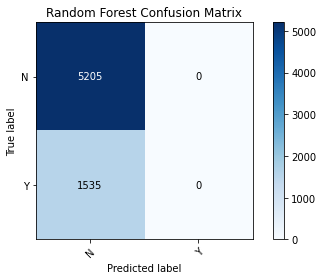

2023/01/05 15:26:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training Naive Bayes Model


 14%|█▍        | 1/7 [18:17<1:49:44, 1097.44s/it]

----------------------------------------


 29%|██▊       | 2/7 [19:00<47:32, 570.41s/it]   

----------------------------------------
Exiting loop


Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.5746290801186944
Precision Score : 0.32601880877742945
Recall Score : 0.8130293159609121
F1 Score : 0.46541115047548015
Confusion Matrix : 
[[2625 2580]
 [ 287 1248]]


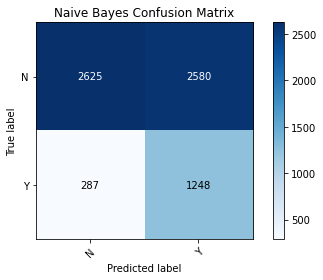

GaussianNB()

In [12]:
learning.semi_supervised_learning(df, experiment_name, df_type='normal', model=rf, threshold=0.7, iterations=7, algorithm='Random Forest', target_column='flagged', log=True)
learning.semi_supervised_learning(df, experiment_name, df_type='normal', model=nb, threshold=0.7, iterations=7, algorithm='Naive Bayes', target_column='flagged', log=True)

2023/01/05 15:45:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training Random Forest Model


 14%|█▍        | 1/7 [00:43<04:20, 43.41s/it]

----------------------------------------


 29%|██▊       | 2/7 [01:21<03:22, 40.56s/it]

----------------------------------------


 43%|████▎     | 3/7 [02:01<02:39, 39.95s/it]

----------------------------------------


 57%|█████▋    | 4/7 [02:55<02:16, 45.43s/it]

----------------------------------------


 71%|███████▏  | 5/7 [03:42<01:32, 46.01s/it]

----------------------------------------


 86%|████████▌ | 6/7 [04:22<00:44, 44.21s/it]

----------------------------------------


100%|██████████| 7/7 [05:07<00:00, 43.89s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.6548501450209475
Precision Score : 0.6156736446591519
Recall Score : 0.7636484687083888
F1 Score : 0.6817236255572064
Confusion Matrix : 
[[ 885  716]
 [ 355 1147]]


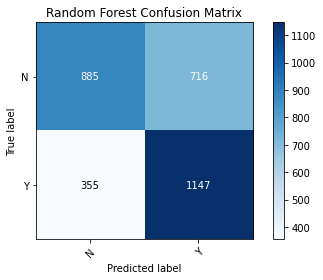

2023/01/05 15:50:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training Naive Bayes Model


 14%|█▍        | 1/7 [06:16<37:39, 376.51s/it]

----------------------------------------


 29%|██▊       | 2/7 [06:42<16:46, 201.39s/it]

----------------------------------------
Exiting loop


Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.6638736706413149
Precision Score : 0.6172713336739908
Recall Score : 0.8042609853528628
F1 Score : 0.6984677652500723
Confusion Matrix : 
[[ 852  749]
 [ 294 1208]]


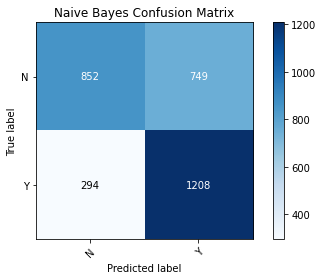

GaussianNB()

In [13]:
learning.semi_supervised_learning(under_sampled_df, experiment_name, df_type='under_sampled', model=rf, threshold=0.7, iterations=7, algorithm='Random Forest', target_column='flagged', log=True)
learning.semi_supervised_learning(under_sampled_df, experiment_name, df_type='under_sampled', model=nb, threshold=0.7, iterations=7, algorithm='Naive Bayes', target_column='flagged', log=True)

2023/01/05 15:57:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training Random Forest Model


 14%|█▍        | 1/7 [03:39<21:54, 219.09s/it]

----------------------------------------


 29%|██▊       | 2/7 [05:47<13:49, 165.90s/it]

----------------------------------------


 43%|████▎     | 3/7 [07:33<09:13, 138.29s/it]

----------------------------------------


 57%|█████▋    | 4/7 [09:07<06:02, 120.75s/it]

----------------------------------------


 71%|███████▏  | 5/7 [10:38<03:40, 110.24s/it]

----------------------------------------


 86%|████████▌ | 6/7 [12:10<01:43, 103.83s/it]

----------------------------------------


100%|██████████| 7/7 [13:45<00:00, 117.88s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.7589629915188898
Precision Score : 0.7043977633368596
Recall Score : 0.8953131002689205
F1 Score : 0.788463165017339
Confusion Matrix : 
[[3214 1956]
 [ 545 4661]]


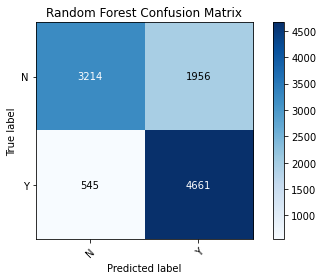

2023/01/05 16:11:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training Naive Bayes Model


 14%|█▍        | 1/7 [37:03<3:42:22, 2223.70s/it]

----------------------------------------


 29%|██▊       | 2/7 [38:10<1:35:26, 1145.21s/it]

----------------------------------------
Exiting loop


Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.6684656900539707
Precision Score : 0.6315162347333929
Recall Score : 0.8144448713023434
F1 Score : 0.7114093959731543
Confusion Matrix : 
[[2696 2474]
 [ 966 4240]]


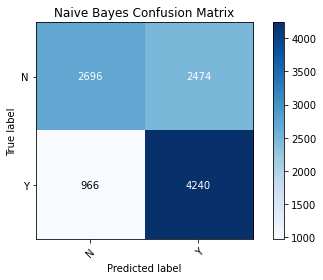

GaussianNB()

In [14]:
learning.semi_supervised_learning(over_sampled_df, experiment_name, df_type='over_sampled', model=rf, threshold=0.7, iterations=7, algorithm='Random Forest', target_column='flagged', log=True)
learning.semi_supervised_learning(over_sampled_df, experiment_name, df_type='over_sampled', model=nb, threshold=0.7, iterations=7, algorithm='Naive Bayes', target_column='flagged', log=True)

In [15]:
# feat_importances = pd.Series(model.feature_importances_, index=feature)
# feat_importances.nlargest(100).plot(kind='barh',figsize=(25,25))

In [16]:
# train_df.columns

In [17]:
# sort = model.feature_importances_.argsort()
# plt.barh(boston.feature_names[sort], model.feature_importances_[sort])
# plt.xlabel("Feature Importance")